[//]: # REMOVE_FOR_WEBSITE
*Copyright 2023 Modular, Inc: Licensed under the Apache License v2.0 with LLVM Exceptions.*

[//]: # REMOVE_FOR_WEBSITE
# Ray tracing in Mojo

This tutorial about [ray
tracing](https://en.wikipedia.org/wiki/Ray_tracing_(graphics)) is based on the
popular tutorial [Understandable RayTracing in
C++](https://github.com/ssloy/tinyraytracer/wiki/Part-1:-understandable-raytracing).
The mathematical explanations are well described in that tutorial, so we'll
just point you to the appropriate sections for reference as we implement a
basic ray tracer in Mojo.

## Step 1: Basic definitions

We'll start by defining a `Vec3f` struct, which will use to represent a vector
in 3D space as well as RGB pixels. We'll use a `SIMD` representation for our
vector to enable vectorized operations. The `SIMD` type is a fixed-size vector,
and its size must be a power of 2. So we'll use a size of 4 and always pad the
underlying storage with a 0.

In [1]:
from math import rsqrt


@register_passable("trivial")
struct Vec3f:
    var data: SIMD[DType.float32, 4]

    @always_inline
    fn __init__(inout self, x: Float32, y: Float32, z: Float32):
        self.data = SIMD[DType.float32, 4](x, y, z, 0)

    @always_inline
    fn __init__(inout self, data: SIMD[DType.float32, 4]):
        self.data = data

    @always_inline
    @staticmethod
    fn zero() -> Vec3f:
        return Vec3f(0, 0, 0)

    @always_inline
    fn __sub__(self, other: Vec3f) -> Vec3f:
        return self.data - other.data

    @always_inline
    fn __add__(self, other: Vec3f) -> Vec3f:
        return self.data + other.data

    @always_inline
    fn __matmul__(self, other: Vec3f) -> Float32:
        return (self.data * other.data).reduce_add()

    @always_inline
    fn __mul__(self, k: Float32) -> Vec3f:
        return self.data * k

    @always_inline
    fn __neg__(self) -> Vec3f:
        return self.data * -1.0

    @always_inline
    fn __getitem__(self, idx: Int) -> SIMD[DType.float32, 1]:
        return self.data[idx]

    @always_inline
    fn cross(self, other: Vec3f) -> Vec3f:
        var self_zxy = self.data.shuffle[2, 0, 1, 3]()
        var other_zxy = other.data.shuffle[2, 0, 1, 3]()
        return (self_zxy * other.data - self.data * other_zxy).shuffle[
            2, 0, 1, 3
        ]()

    @always_inline
    fn normalize(self) -> Vec3f:
        return self.data * rsqrt(self @ self)


We now define our `Image` struct, which will store the RGB pixels of our
images. It also contains a method to convert this Mojo struct into a NumPy
image, which will be used for implementing a straightforward display
mechanism. We will also implement a function for loading PNG files from disk.

First install the required libraries:

In [2]:
%%python
from importlib.util import find_spec
import shutil
import subprocess

fix = """
-------------------------------------------------------------------------
fix following the steps here:
    https://github.com/modularml/mojo/issues/1085#issuecomment-1771403719
-------------------------------------------------------------------------
"""

def install_if_missing(name: str):
    if find_spec(name):
        return

    print(f"{name} not found, installing...")
    try:
        if shutil.which('python3'): python = "python3"
        elif shutil.which('python'): python = "python"
        else: raise ("python not on path" + fix)
        subprocess.check_call([python, "-m", "pip", "install", name])
    except:
        raise ImportError(f"{name} not found" + fix)

install_if_missing("numpy")
install_if_missing("matplotlib")


In [3]:
from python import Python
from python import PythonObject
from memory.unsafe_pointer import UnsafePointer

struct Image:
    # reference count used to make the object efficiently copyable
    var rc: UnsafePointer[Int]
    # the two dimensional image is represented as a flat array
    var pixels: UnsafePointer[Vec3f]
    var height: Int
    var width: Int

    fn __init__(inout self, height: Int, width: Int):
        self.height = height
        self.width = width
        self.pixels = UnsafePointer[Vec3f].alloc(self.height * self.width)
        self.rc = UnsafePointer[Int].alloc(1)
        self.rc[] = 1

    fn __copyinit__(inout self, other: Self):
        other._inc_rc()
        self.pixels = other.pixels
        self.rc = other.rc
        self.height = other.height
        self.width = other.width

    fn __del__(owned self):
        self._dec_rc()

    fn _dec_rc(self):
        if self.rc[] > 1:
            self.rc[] -= 1
            return
        self._free()

    fn _inc_rc(self):
        self.rc[] += 1

    fn _free(self):
        self.rc.free()
        self.pixels.free()

    @always_inline
    fn set(self, row: Int, col: Int, value: Vec3f) -> None:
        self.pixels[self._pos_to_index(row, col)] = value

    @always_inline
    fn _pos_to_index(self, row: Int, col: Int) -> Int:
        # Convert a (rol, col) position into an index in the underlying linear storage
        return row * self.width + col

    def to_numpy_image(self) -> PythonObject:
        var np = Python.import_module("numpy")
        var plt = Python.import_module("matplotlib.pyplot")

        var np_image = np.zeros((self.height, self.width, 3), np.float32)

        # We use raw pointers to efficiently copy the pixels to the numpy array
        var out_pointer = UnsafePointer[Float32](
            address=int(np_image.__array_interface__["data"][0])
        )
        var in_pointer = self.pixels.bitcast[Float32]()

        for row in range(self.height):
            for col in range(self.width):
                var index = self._pos_to_index(row, col)
                for dim in range(3):
                    out_pointer[index * 3 + dim] = in_pointer[index * 4 + dim]

        return np_image


def load_image(fname: String) -> Image:
    var np = Python.import_module("numpy")
    var plt = Python.import_module("matplotlib.pyplot")

    var np_image = plt.imread(fname)
    var rows = int(np_image.shape[0])
    var cols = int(np_image.shape[1])
    var image = Image(rows, cols)

    var in_pointer = UnsafePointer[Float32](
        address=int(np_image.__array_interface__["data"][0])
    )
    var out_pointer = image.pixels.bitcast[Float32]()

    for row in range(rows):
        for col in range(cols):
            var index = image._pos_to_index(row, col)
            for dim in range(3):
                out_pointer[index * 4 + dim] = in_pointer[index * 3 + dim]
    return image


We then add a function for quickly displaying an `Image` into the notebook. Our
Python interop comes in quite handy.

In [4]:
def render(image: Image):
    np = Python.import_module("numpy")
    plt = Python.import_module("matplotlib.pyplot")
    colors = Python.import_module("matplotlib.colors")
    dpi = 32
    fig = plt.figure(1, [image.width // 10, image.height // 10], dpi)

    plt.imshow(image.to_numpy_image())
    plt.axis("off")
    plt.show()


Finally, we test all our code so far with a simple image, which is the one
rendered in the [Step 1 of the C++
tutorial](https://github.com/ssloy/tinyraytracer/wiki/Part-1:-understandable-raytracing#step-1-write-an-image-to-the-disk).

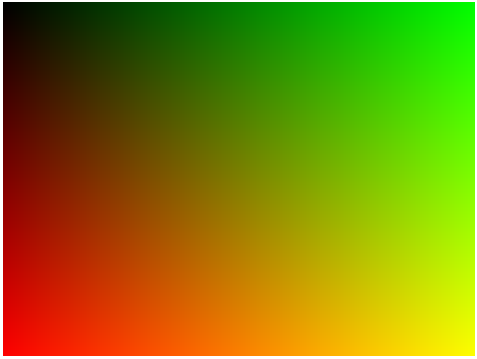

In [5]:
var image = Image(192, 256)

for row in range(image.height):
    for col in range(image.width):
        image.set(
            row,
            col,
            Vec3f(Float32(row) / image.height, Float32(col) / image.width, 0),
        )

render(image)


## Step 2: Ray tracing

Now we'll perform ray tracing from a camera into a scene with a sphere. Before
reading the code below, we suggest you read more about how this works
conceptually from [Step 2 of the C++
tutorial](https://github.com/ssloy/tinyraytracer/wiki/Part-1:-understandable-raytracing#step-2-the-crucial-one-ray-tracing).

We first define the `Material` and `Sphere` structs, which are the new data
structures we'll need.

In [14]:
from math import sqrt

@register_passable("trivial")
struct Material:
    var color: Vec3f
    var albedo: Vec3f
    var specular_component: Float32

    fn __init__(inout self, color: Vec3f, albedo: Vec3f = Vec3f(0, 0, 0),
                specular_component: Float32 = 0):
        self.color = color
        self.albedo = albedo
        self.specular_component = specular_component

alias W = 1024
alias H = 768
alias bg_color = Vec3f(0.02, 0.02, 0.02)
var shiny_yellow = Material(Vec3f(0.95, 0.95, 0.4), Vec3f(0.7, 0.6, 0), 30.0)
var green_rubber = Material(Vec3f( 0.3,  0.7, 0.3), Vec3f(0.9, 0.1, 0), 1.0)


@value
@register_passable("trivial")
struct Sphere(CollectionElement):
    var center: Vec3f
    var radius: Float32
    var material: Material

    @always_inline
    fn intersects(self, orig: Vec3f, dir: Vec3f, inout dist: Float32) -> Bool:
        """This method returns True if a given ray intersects this sphere.
        And if it does, it writes in the `dist` parameter the distance to the
        origin of the ray.
        """
        var L = orig - self.center
        var a = dir @ dir
        var b = 2 * (dir @ L)
        var c = L @ L - self.radius * self.radius
        var discriminant = b * b - 4 * a * c
        if discriminant < 0:
            return False
        if discriminant == 0:
            dist = -b / 2 * a
            return True
        var q = -0.5 * (b + sqrt(discriminant)) if b > 0 else -0.5 * (
            b - sqrt(discriminant)
        )
        var t0 = q / a
        var t1 = c / q
        if t0 > t1:
            t0 = t1
        if t0 < 0:
            t0 = t1
            if t0 < 0:
                return False

        dist = t0
        return True


We then define a `cast_ray` method, which will be used to figure out the color
of a particular pixel in the image we'll produce. It basically works by
identifying whether this ray intersects the sphere or not.

In [7]:
fn cast_ray(orig: Vec3f, dir: Vec3f, sphere: Sphere) -> Vec3f:
    var dist: Float32 = 0
    if not sphere.intersects(orig, dir, dist):
        return bg_color

    return sphere.material.color


Lastly, we parallelize the ray tracing for every pixel row-wise.

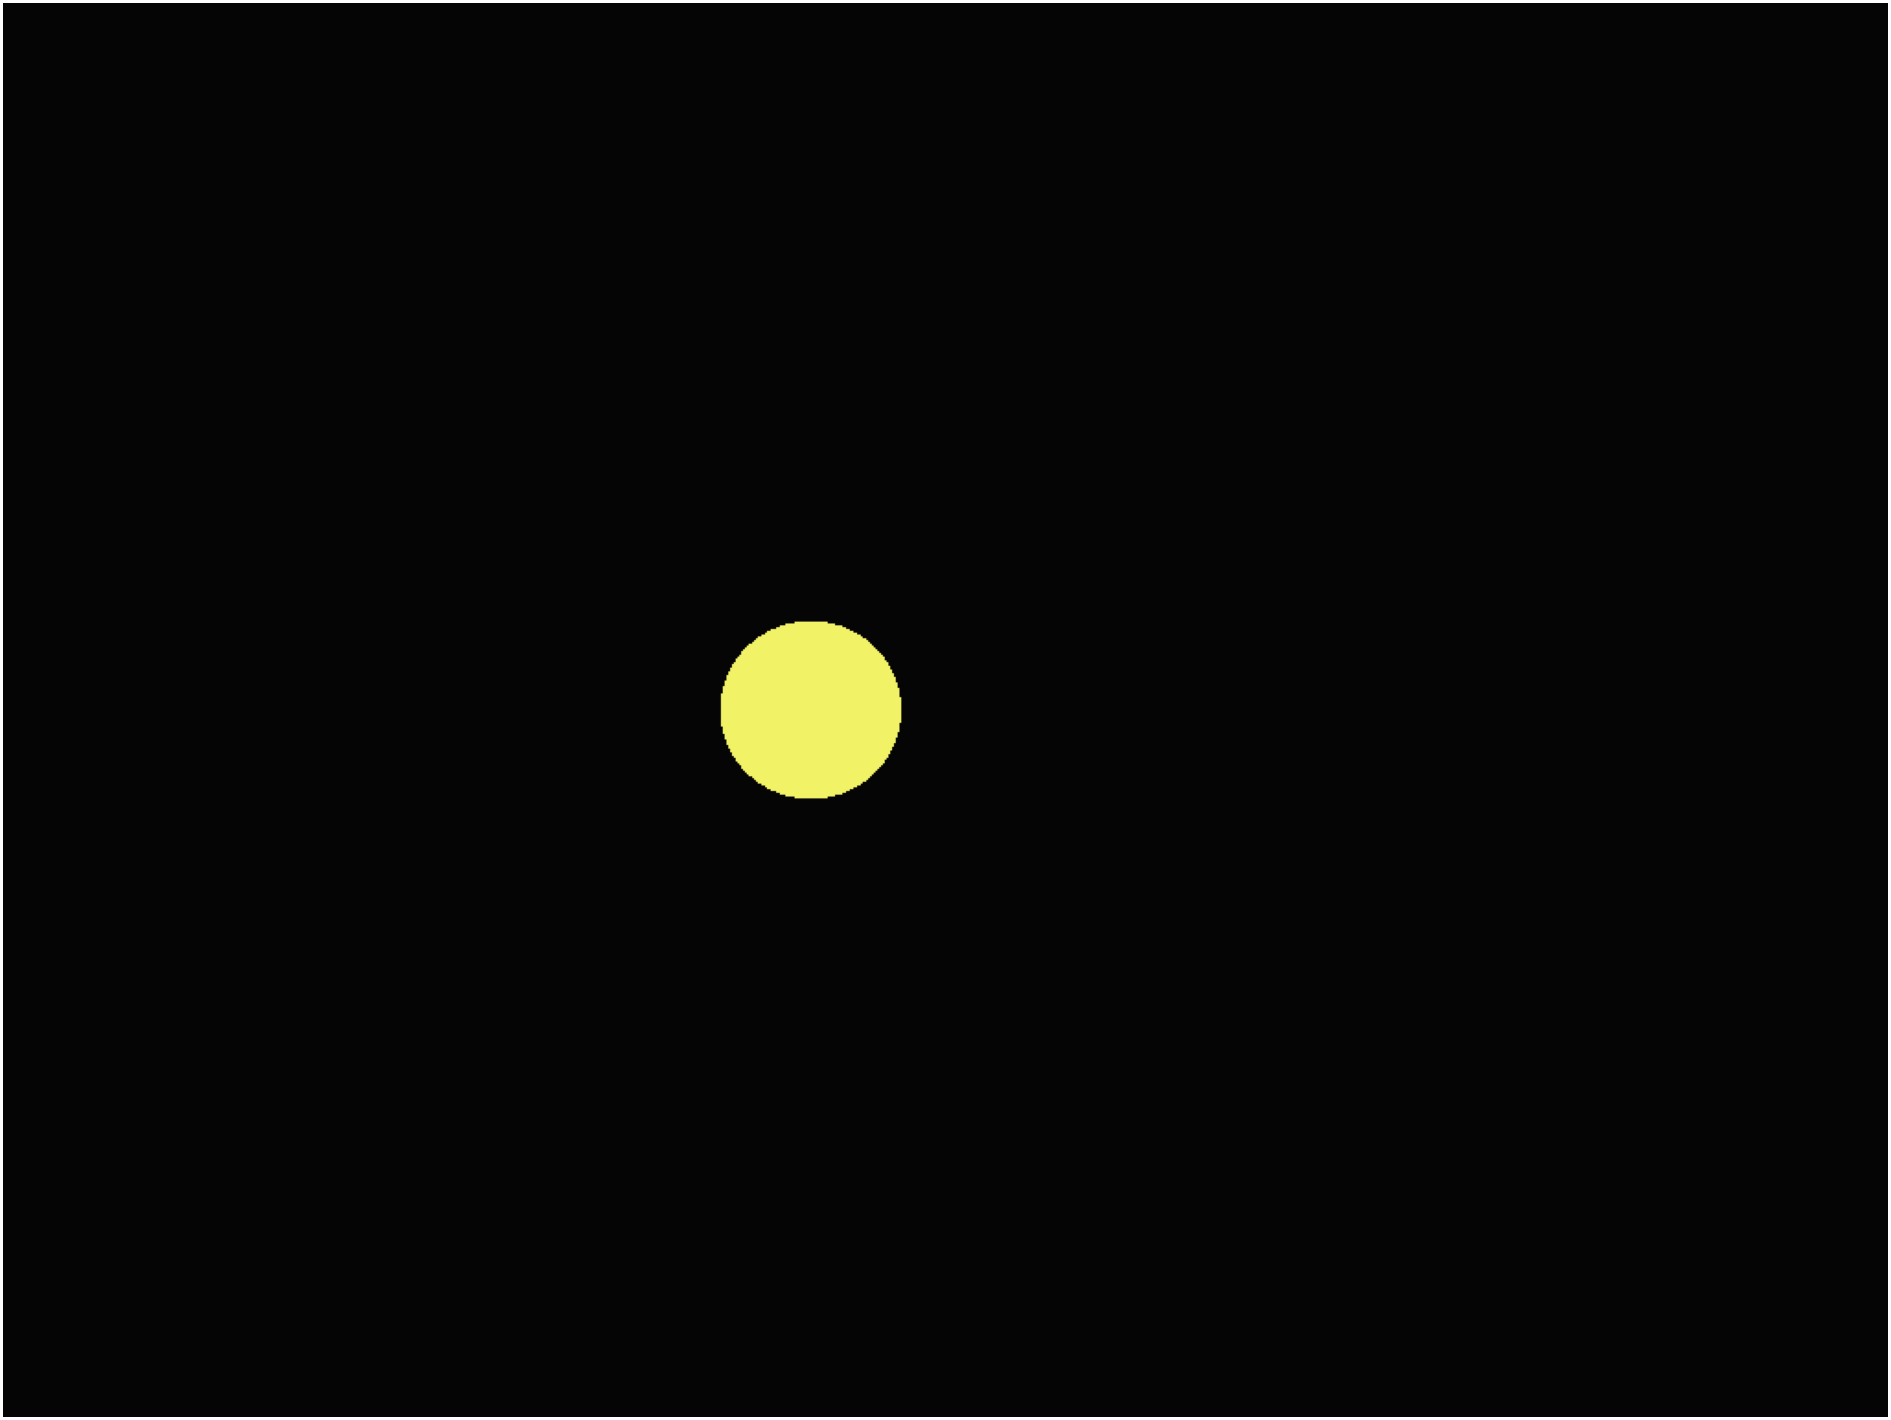

In [8]:
from math import tan, acos
from algorithm import parallelize


fn create_image_with_sphere(sphere: Sphere, height: Int, width: Int) -> Image:
    var image = Image(height, width)

    @parameter
    fn _process_row(row: Int):
        var y = -((2.0 * row + 1) / height - 1)
        for col in range(width):
            var x = ((2.0 * col + 1) / width - 1) * width / height
            var dir = Vec3f(x, y, -1).normalize()
            image.set(row, col, cast_ray(Vec3f.zero(), dir, sphere))

    parallelize[_process_row](height)

    return image


render(
    create_image_with_sphere(Sphere(Vec3f(-3, 0, -16), 2, shiny_yellow), H, W)
)


## Step 3: More spheres

This section corresponds to the [Step 3 of the C++
tutorial](https://github.com/ssloy/tinyraytracer/wiki/Part-1:-understandable-raytracing#step-3-add-more-spheres).

We include here all the necessary changes:

- We add 3 more spheres to the scene, 2 of them being of green rubber material.
- When we intersect the ray with the sphere, we render the color of the closest
  sphere.

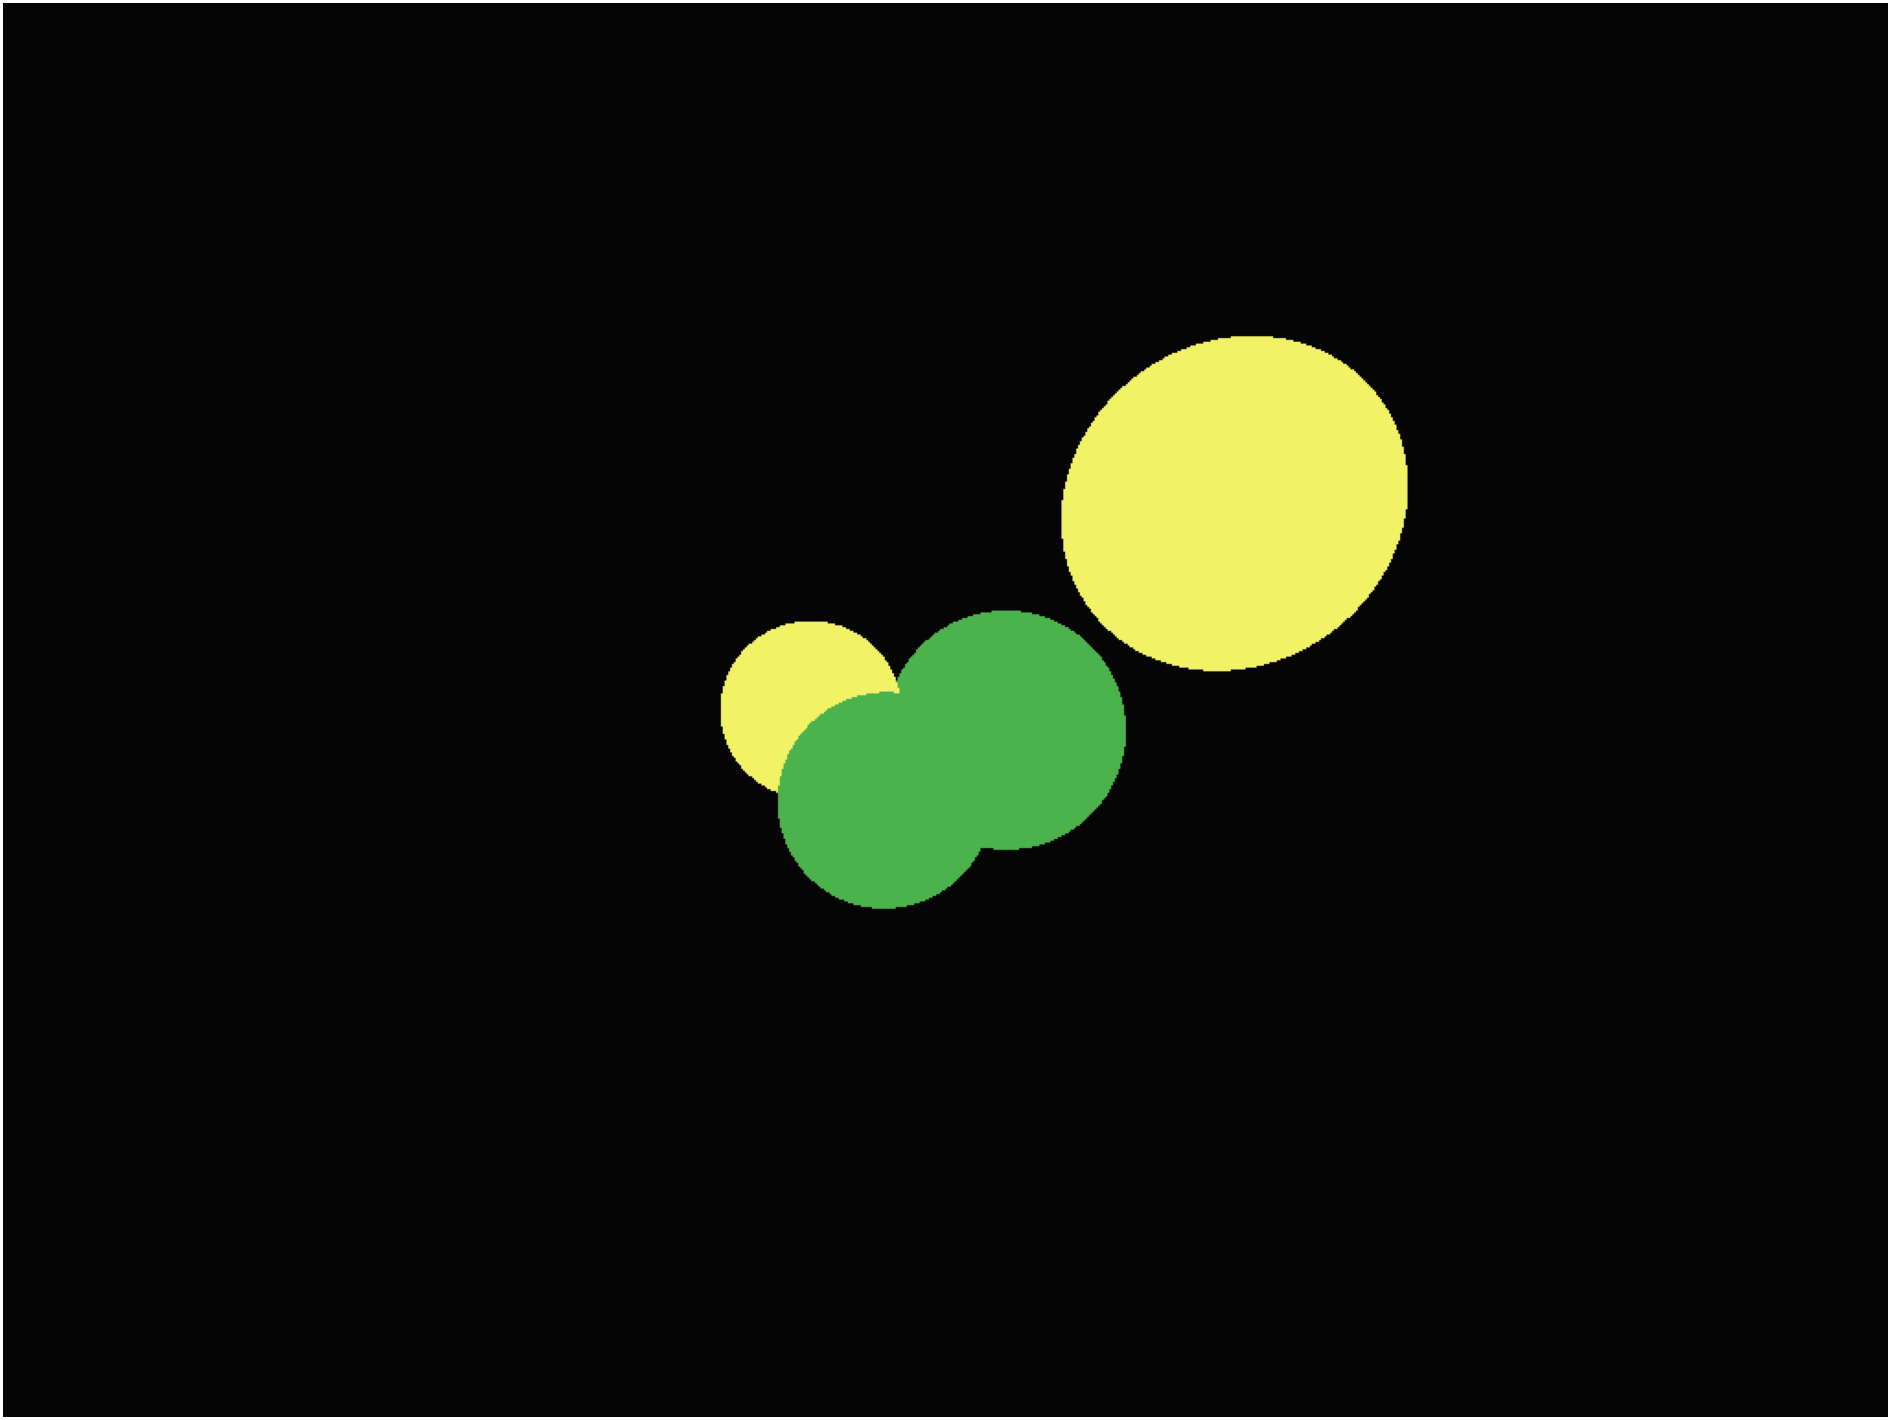

In [9]:
from algorithm import parallelize
from utils.numerics import inf
from collections import List


fn scene_intersect(
    orig: Vec3f,
    dir: Vec3f,
    spheres: List[Sphere],
    background: Material,
) -> Material:
    var spheres_dist = inf[DType.float32]()
    var material = background

    for i in range(spheres.size):
        var dist = inf[DType.float32]()
        if spheres[i].intersects(orig, dir, dist) and dist < spheres_dist:
            spheres_dist = dist
            material = spheres[i].material

    return material


fn cast_ray(
    orig: Vec3f, dir: Vec3f, spheres: List[Sphere]
) -> Material:
    var background = Material(Vec3f(0.02, 0.02, 0.02))
    return scene_intersect(orig, dir, spheres, background)


fn create_image_with_spheres(
    spheres: List[Sphere], height: Int, width: Int
) -> Image:
    var image = Image(height, width)

    @parameter
    fn _process_row(row: Int):
        var y = -((2.0 * row + 1) / height - 1)
        for col in range(width):
            var x = ((2.0 * col + 1) / width - 1) * width / height
            var dir = Vec3f(x, y, -1).normalize()
            image.set(row, col, cast_ray(Vec3f.zero(), dir, spheres).color)

    parallelize[_process_row](height)

    return image

var spheres = List[Sphere]()
spheres.append(Sphere(Vec3f(-3,      0, -16),   2, shiny_yellow))
spheres.append(Sphere(Vec3f(-1.0, -1.5, -12), 1.8, green_rubber))
spheres.append(Sphere(Vec3f( 1.5, -0.5, -18),   3, green_rubber))
spheres.append(Sphere(Vec3f( 7,      5, -18),   4, shiny_yellow))

render(create_image_with_spheres(spheres, H, W))


## Step 4: Add lighting

This section corresponds to the [Step 4 of the C++
tutorial](https://github.com/ssloy/tinyraytracer/wiki/Part-1:-understandable-raytracing#step-4-lighting).
Please read that section for an explanation of the trick used to estimate the
light intensity of pixel based on the angle of intersection between each ray
and the spheres. The changes are minimal and are primarily about handling this
intersection angle.

In [10]:
@value
@register_passable("trivial")
struct Light(CollectionElement):
    var position: Vec3f
    var intensity: Float32

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


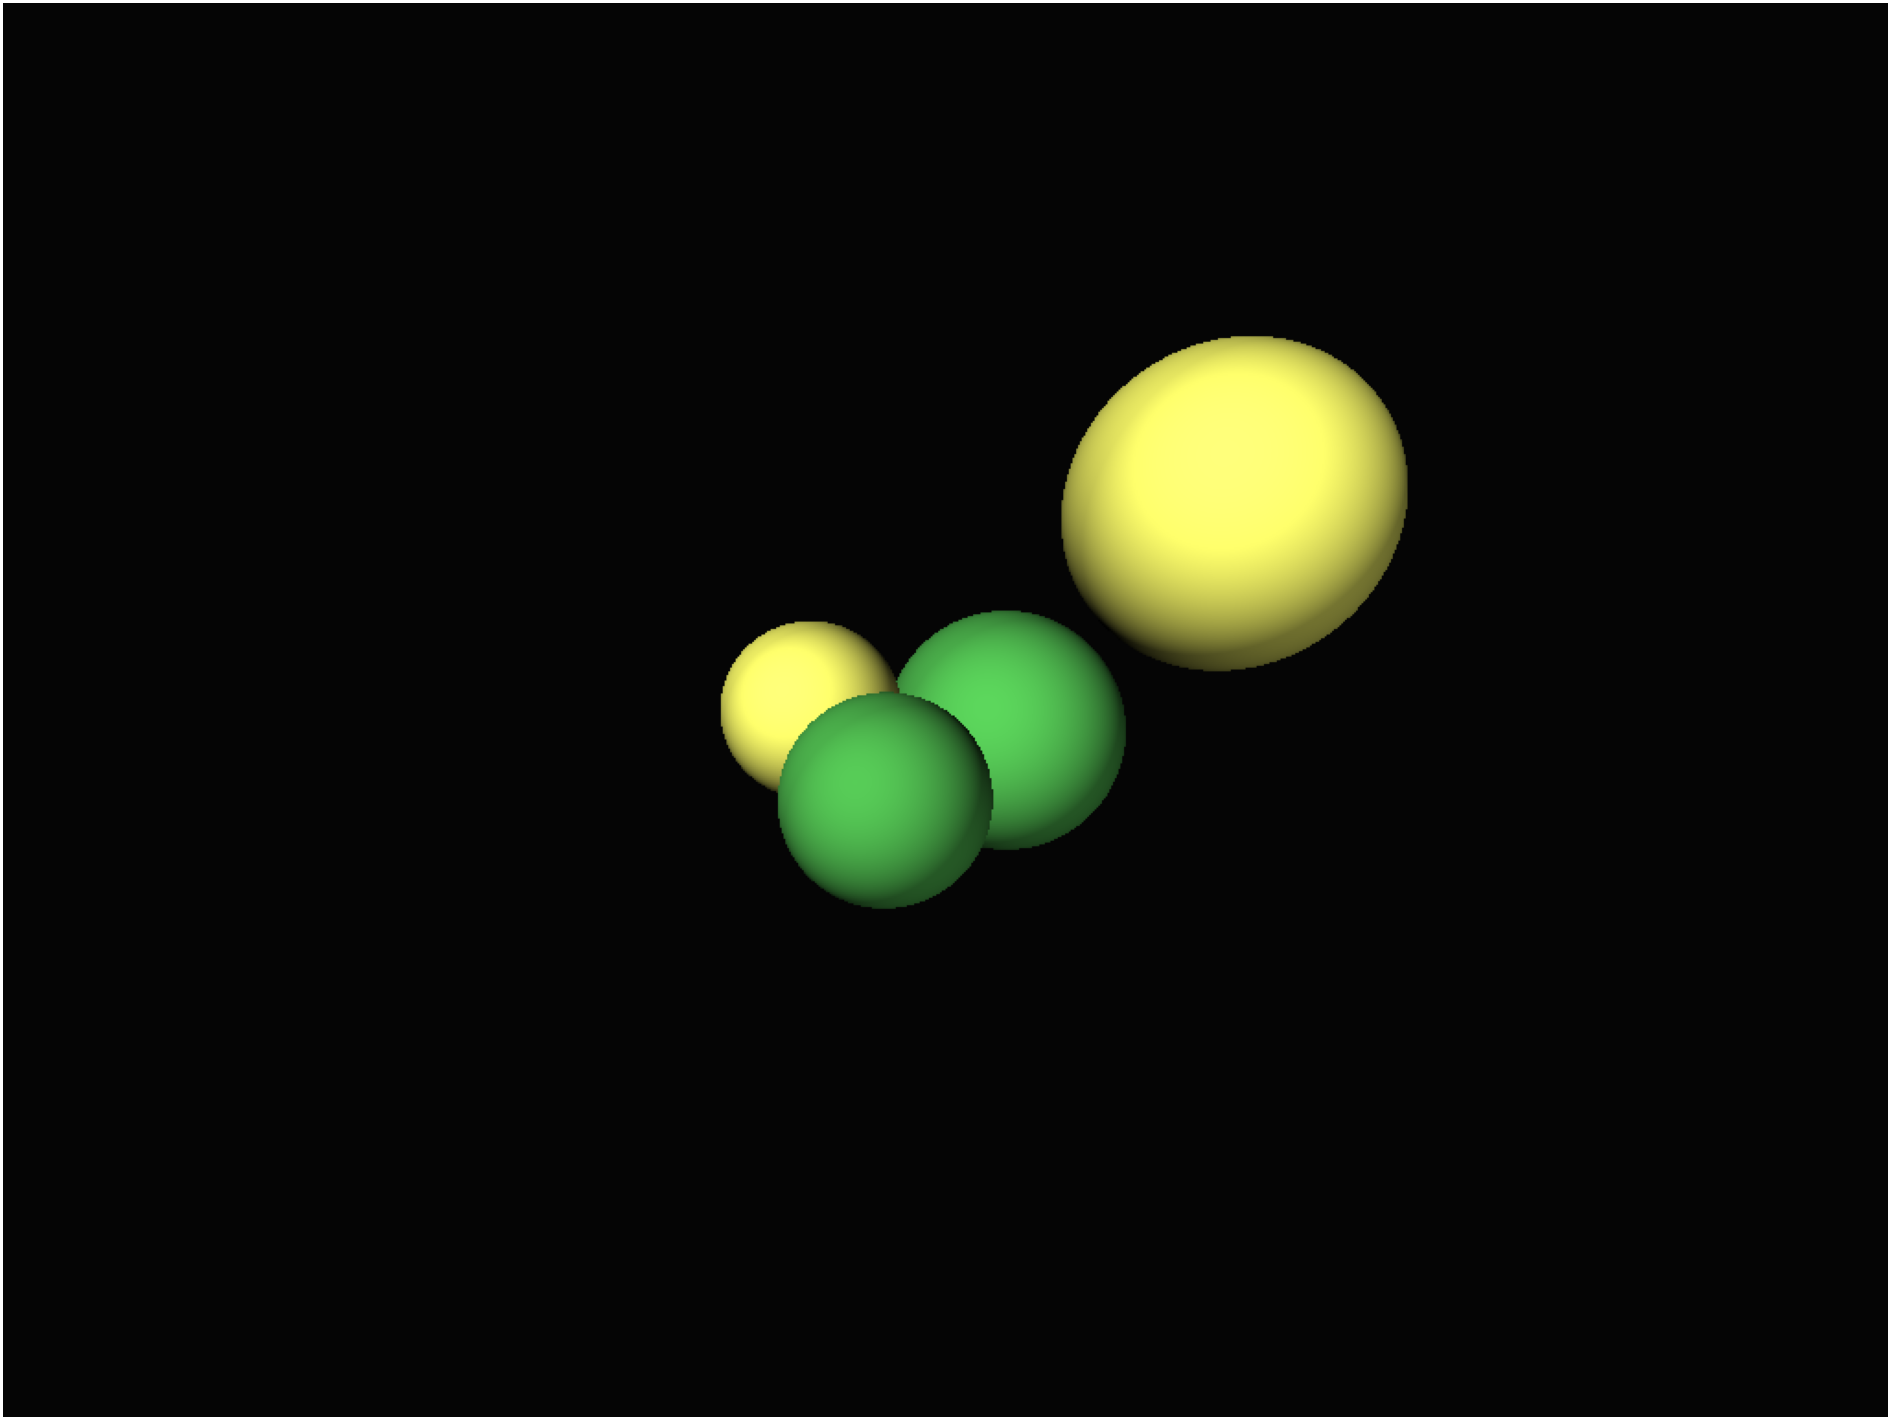

In [11]:
fn scene_intersect(
    orig: Vec3f,
    dir: Vec3f,
    spheres: List[Sphere],
    inout material: Material,
    inout hit: Vec3f,
    inout N: Vec3f,
) -> Bool:
    var spheres_dist = inf[DType.float32]()

    for i in range(0, spheres.size):
        var dist: Float32 = 0
        if spheres[i].intersects(orig, dir, dist) and dist < spheres_dist:
            spheres_dist = dist
            hit = orig + dir * dist
            N = (hit - spheres[i].center).normalize()
            material = spheres[i].material

    return (spheres_dist != inf[DType.float32]())


fn cast_ray(
    orig: Vec3f,
    dir: Vec3f,
    spheres: List[Sphere],
    lights: List[Light],
) -> Material:
    var point = Vec3f.zero()
    var material = Material(Vec3f.zero())
    var N = Vec3f.zero()
    if not scene_intersect(orig, dir, spheres, material, point, N):
        return bg_color

    var diffuse_light_intensity: Float32 = 0
    for i in range(lights.size):
        var light_dir = (lights[i].position - point).normalize()
        diffuse_light_intensity += lights[i].intensity * max(light_dir @ N, 0)

    return material.color * diffuse_light_intensity


fn create_image_with_spheres_and_lights(
    spheres: List[Sphere],
    lights: List[Light],
    height: Int,
    width: Int,
) -> Image:
    var image = Image(height, width)

    @parameter
    fn _process_row(row: Int):
        var y = -((2.0 * row + 1) / height - 1)
        for col in range(width):
            var x = ((2.0 * col + 1) / width - 1) * width / height
            var dir = Vec3f(x, y, -1).normalize()
            image.set(
                row, col, cast_ray(Vec3f.zero(), dir, spheres, lights).color
            )

    parallelize[_process_row](height)

    return image


var lights = List[Light]()
lights.append(Light(Vec3f(-20, 20, 20), 1.0))
lights.append(Light(Vec3f(20, -20, 20), 0.5))

render(create_image_with_spheres_and_lights(spheres, lights, H, W))


## Step 5: Add specular lighting

This section corresponds to the [Step 5 of the C++
tutorial](https://github.com/ssloy/tinyraytracer/wiki/Part-1:-understandable-raytracing#step-5-specular-lighting).
The changes to the code are quite minimal, but the rendered picture looks much
more realistic!

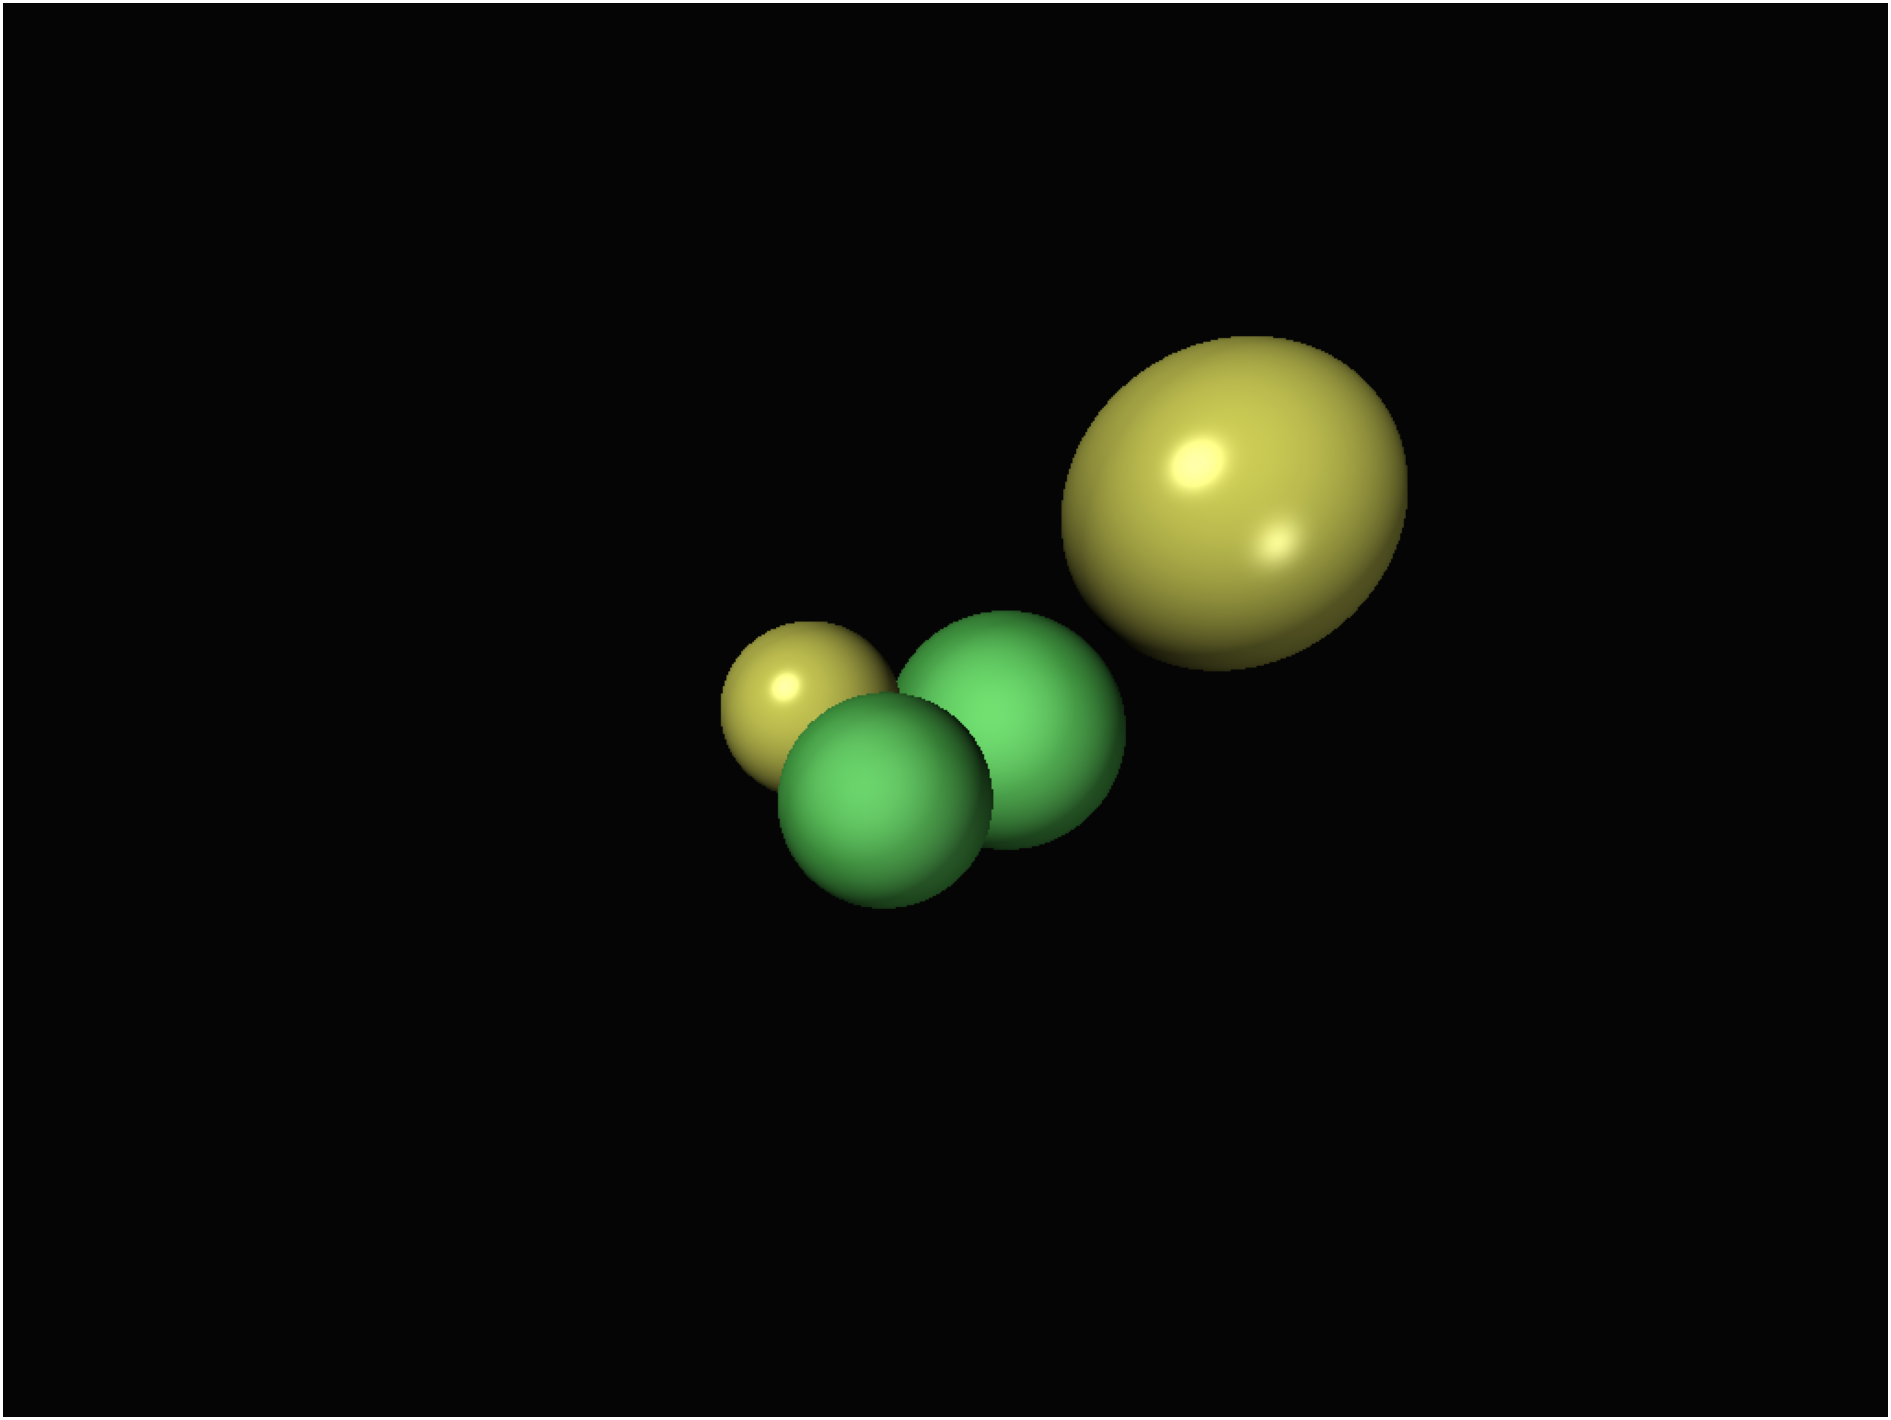

In [12]:
fn reflect(I: Vec3f, N: Vec3f) -> Vec3f:
    return I - N * (I @ N) * 2.0


fn cast_ray(
    orig: Vec3f,
    dir: Vec3f,
    spheres: List[Sphere],
    lights: List[Light],
) -> Material:
    var point = Vec3f.zero()
    var material = Material(Vec3f.zero())
    var N = Vec3f.zero()
    if not scene_intersect(orig, dir, spheres, material, point, N):
        return bg_color

    var diffuse_light_intensity: Float32 = 0
    var specular_light_intensity: Float32 = 0
    for i in range(lights.size):
        var light_dir = (lights[i].position - point).normalize()
        diffuse_light_intensity += lights[i].intensity * max(light_dir @ N, 0)
        specular_light_intensity += (
            pow(
                max(-reflect(-light_dir, N) @ dir, 0.0),
                material.specular_component,
            )
            * lights[i].intensity
        )

    var result = material.color * diffuse_light_intensity * material.albedo.data[
        0
    ] + Vec3f(
        1.0, 1.0, 1.0
    ) * specular_light_intensity * material.albedo.data[
        1
    ]
    var result_max = max(result[0], max(result[1], result[2]))
    # Cap the resulting vector
    if result_max > 1:
        return result * (1.0 / result_max)
    return result


fn create_image_with_spheres_and_specular_lights(
    spheres: List[Sphere],
    lights: List[Light],
    height: Int,
    width: Int,
) -> Image:
    var image = Image(height, width)

    @parameter
    fn _process_row(row: Int):
        var y = -((2.0 * row + 1) / height - 1)
        for col in range(width):
            var x = ((2.0 * col + 1) / width - 1) * width / height
            var dir = Vec3f(x, y, -1).normalize()
            image.set(
                row, col, cast_ray(Vec3f.zero(), dir, spheres, lights).color
            )

    parallelize[_process_row](height)

    return image

render(create_image_with_spheres_and_specular_lights(spheres, lights, H, W))


## Step 6: Add background

As a last step, let's use an image for the background instead of a uniform
fill. The only code that we need to change is the code where we used to return
`bg_color`. Now we will determine a point in the background image to which the
ray is directed and draw that.

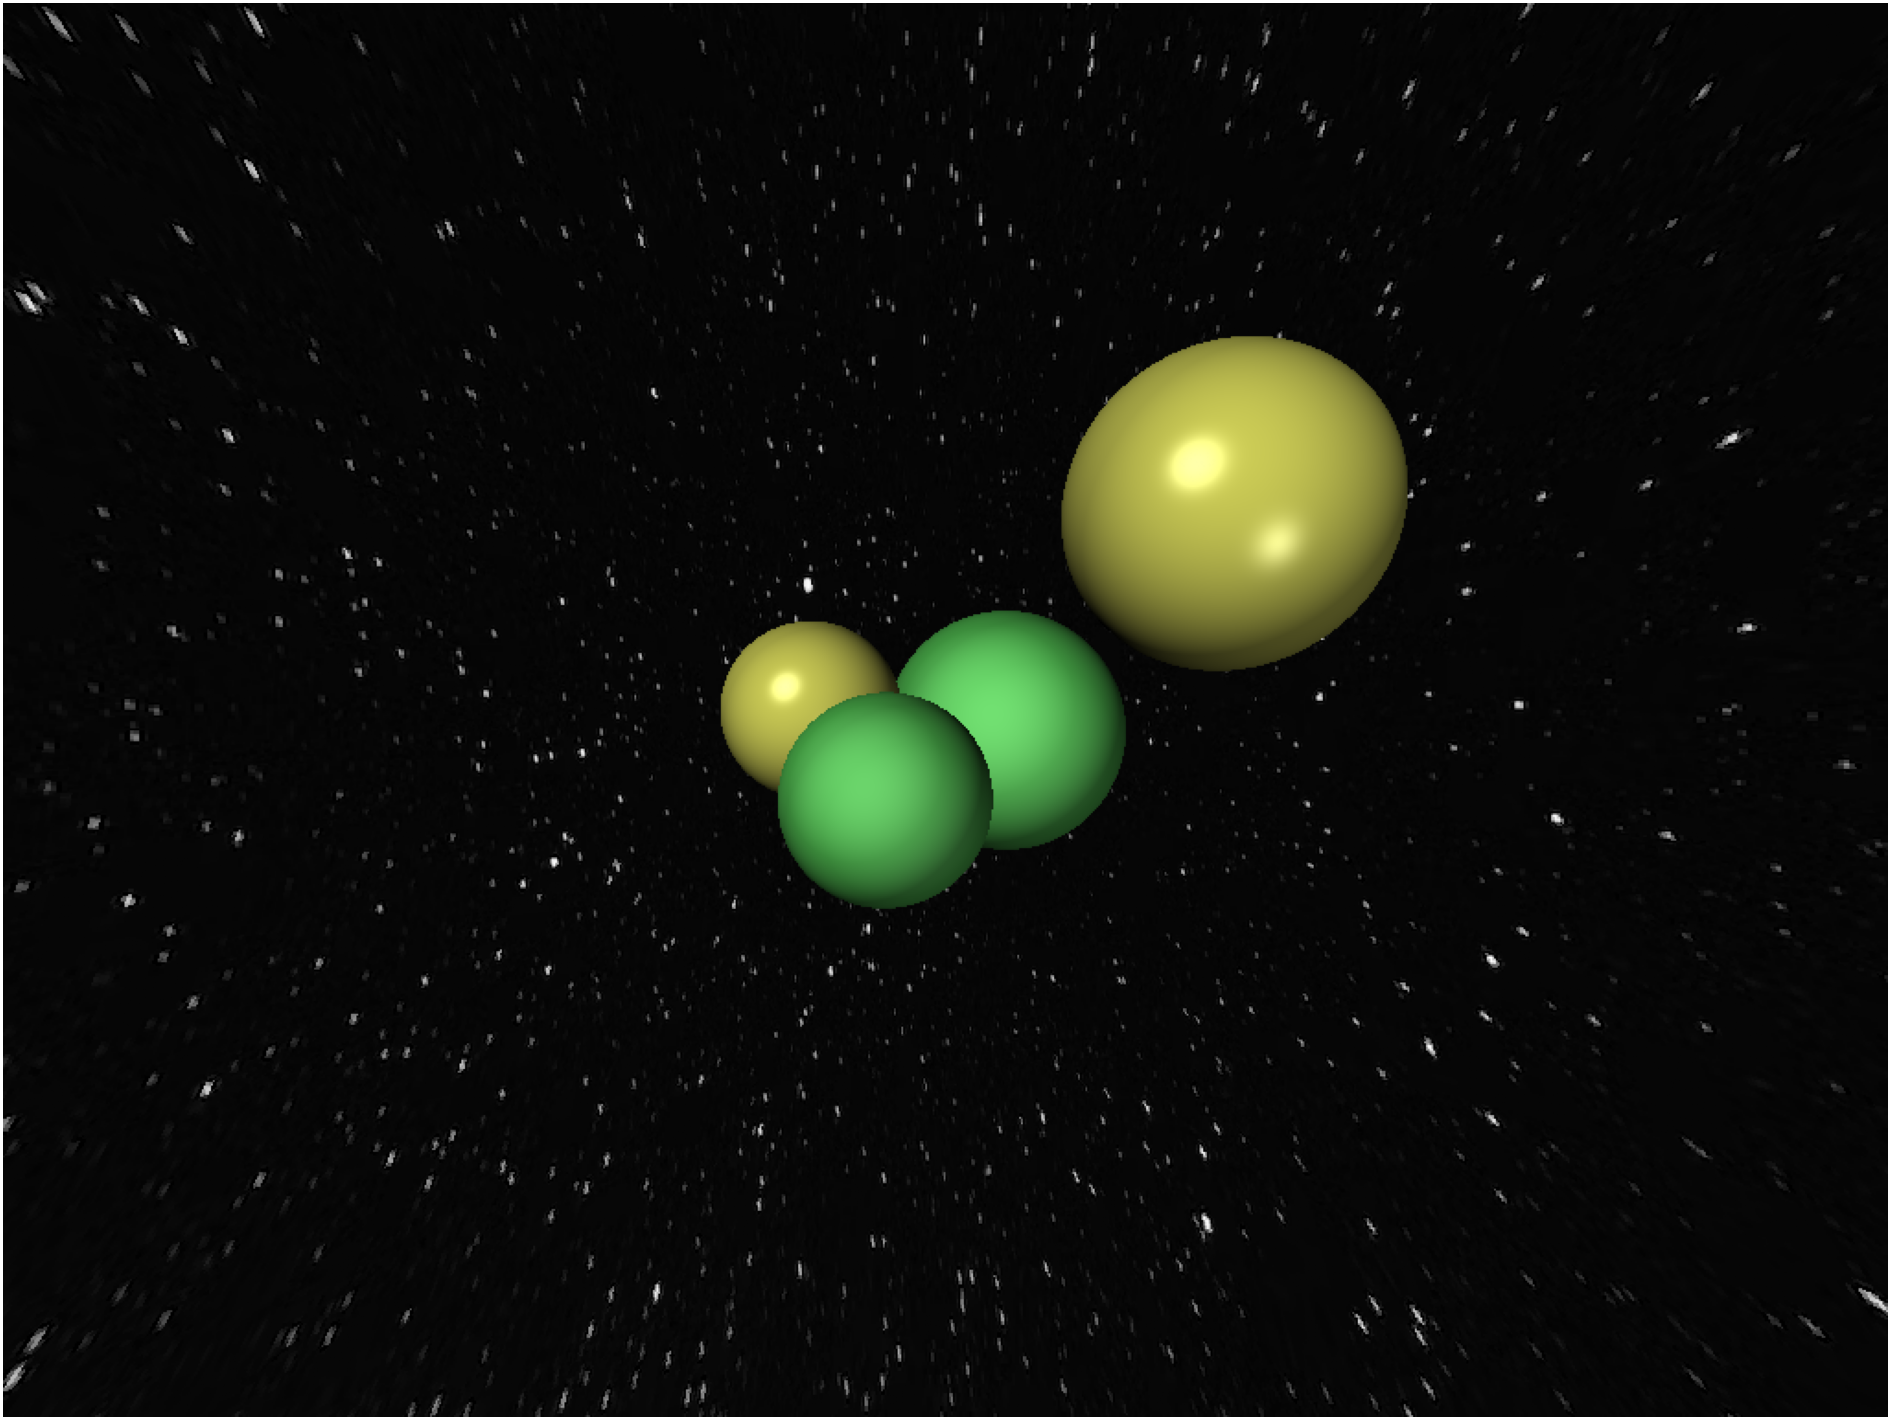

In [13]:
fn cast_ray(
    orig: Vec3f,
    dir: Vec3f,
    spheres: List[Sphere],
    lights: List[Light],
    bg: Image,
) -> Material:
    var point = Vec3f.zero()
    var material = Material(Vec3f.zero())
    var N = Vec3f.zero()
    if not scene_intersect(orig, dir, spheres, material, point, N):
        # Background
        # Given a direction vector `dir` we need to find a pixel in the image
        var x = dir[0]
        var y = dir[1]

        # Now map x from [-1,1] to [0,w-1] and do the same for y.
        var w = bg.width
        var h = bg.height
        var col = int((1.0 + x) * 0.5 * (w - 1))
        var row = int((1.0 + y) * 0.5 * (h - 1))
        return Material(bg.pixels[bg._pos_to_index(row, col)])

    var diffuse_light_intensity: Float32 = 0
    var specular_light_intensity: Float32 = 0
    for i in range(lights.size):
        var light_dir = (lights[i].position - point).normalize()
        diffuse_light_intensity += lights[i].intensity * max(light_dir @ N, 0)
        specular_light_intensity += (
            pow(
                max(-reflect(-light_dir, N) @ dir, 0.0),
                material.specular_component,
            )
            * lights[i].intensity
        )

    var result = material.color * diffuse_light_intensity * material.albedo.data[
        0
    ] + Vec3f(
        1.0, 1.0, 1.0
    ) * specular_light_intensity * material.albedo.data[
        1
    ]
    var result_max = max(result[0], max(result[1], result[2]))
    # Cap the resulting vector
    if result_max > 1:
        return result * (1.0 / result_max)
    return result


fn create_image_with_spheres_and_specular_lights(
    spheres: List[Sphere],
    lights: List[Light],
    height: Int,
    width: Int,
    bg: Image,
) -> Image:
    var image = Image(height, width)

    @parameter
    fn _process_row(row: Int):
        var y = -((2.0 * row + 1) / height - 1)
        for col in range(width):
            var x = ((2.0 * col + 1) / width - 1) * width / height
            var dir = Vec3f(x, y, -1).normalize()
            image.set(
                row, col, cast_ray(Vec3f.zero(), dir, spheres, lights, bg).color
            )

    parallelize[_process_row](height)

    return image


var bg = load_image("images/background.png")
render(
    create_image_with_spheres_and_specular_lights(spheres, lights, H, W, bg)
)


## Next steps

We've only explored the basics of ray tracing here, but you can add shadows,
reflections and so much more! Fortunately these are explained in [the C++
tutorial](https://github.com/ssloy/tinyraytracer/wiki/Part-1:-understandable-raytracing),
and we leave the corresponding Mojo implementations as an exercise for you.